In [1]:
import qutip as qt
import numpy as np
import matplotlib.pyplot as plt
from qutip.ipynbtools import version_table
from tqdm.notebook import tqdm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
from matplotlib.patches import Rectangle
import pandas as pd


resol = 300
pi = np.pi
version_table()

#plt.rcParams.update({
#    "text.usetex": True,
#    "font.family": "serif"
#})

Software,Version
QuTiP,5.1.1
Numpy,1.26.2
SciPy,1.11.3
matplotlib,3.7.3
Number of CPUs,11
BLAS Info,Generic
IPython,8.17.2
Python,"3.12.0 (v3.12.0:0fb18b02c8, Oct 2 2023, 09:45:56) [Clang 13.0.0 (clang-1300.0.29.30)]"
OS,posix [darwin]
Cython,3.0.11


In [22]:
def update_state(c,b,gamma,omega_tab,omega_A,L,t, dt):
    """
    Update the state of the system based on the given parameters.
    
    Parameters:
    c (np array): Coefficients in front of the states |1_k, 0>
    b (float): Atomic coefficient in front of the state |0, 1>
    g_0 (float): Coupling strength.
    omega_tab (array): Array of frequencies.
    L (int): Length of the system.
    
    Returns:
    c_new (np array): Updated coefficients.
    b_new (float): Updated atomic coefficient.
    """
    g_matrix_individual = 1j * np.sqrt(gamma / (2*L)) * np.exp(-1j * (omega_tab - omega_A) * t)
    g_matrix = np.concatenate((g_matrix_individual, g_matrix_individual))

    b_new = c @ g_matrix
    c_new = b * np.conjugate(g_matrix)

    return -1j* dt * c_new, -1j * dt * b_new

def RG_scheme(c_init, b_init, gamma, omega_tab, omega_A, L, T, dt, progress_bar=True):
    """
    Propagates the state of the system using the RG scheme.
    
    Parameters:
    c_init (np array): initial coefficients in front of the states |1_k, 0>
    b_init (float): initial atomic coefficient in front of the state |0, 1>
    g_0 (float): Coupling strength.
    omega_tab (array): Array of frequencies.
    L (float): Length of the system.
    T (float): Total time for propagation.
    dt (float): Time step for propagation.
    
    Returns:
    c_array (np array): Array of c coefficients at each time step.
    b_array (np array): Array of b coefficients at each time step.
    """

    nb_pts_time = int(T / dt)
    n_modes = len(c_init)//2
    c_array = np.zeros((nb_pts_time, 2*n_modes), dtype=complex)
    b_array = np.zeros(nb_pts_time, dtype=complex)

    # Set the initial conditions
    c_array[0] = c_init
    b_array[0] = b_init

    # Time evolution loop
    for i in tqdm(range(1, nb_pts_time), disable=not progress_bar):
        t = i * dt
        c_current = c_array[i-1]
        b_current = b_array[i-1]

        c_new_k1, b_new_k1 = update_state(c_current, b_current, gamma, omega_tab, omega_A, L, t, dt)
        c_new_k2, b_new_k2 = update_state(c_current + c_new_k1/2, b_current + b_new_k1/2, gamma, omega_tab, omega_A, L, t + dt/2, dt)
        c_new_k3, b_new_k3 = update_state(c_current + c_new_k2/2, b_current + b_new_k2/2, gamma, omega_tab, omega_A, L, t + dt/2, dt)
        c_new_k4, b_new_k4 = update_state(c_current + c_new_k3, b_current + b_new_k3, gamma, omega_tab, omega_A, L, t + dt, dt)

        c_new = c_current + (c_new_k1 + 2*c_new_k2 + 2*c_new_k3 + c_new_k4) / 6
        b_new = b_current + (b_new_k1 + 2*b_new_k2 + 2*b_new_k3 + b_new_k4) / 6

        c_array[i] = c_new
        b_array[i] = b_new

    return c_array, b_array 

def get_data_mirror_fast(L, T, dt, omega_0, omega_A, omega_max, gamma, sigma, x_0, print_nb_modes = False, progress_bar=True):
    """
    Generate data for the RG scheme with a mirror.
    
    Parameters:
    L (float): Length of the system.
    T (float): Total time for propagation.
    dt (float): Time step for propagation.
    omega_0 (float): Frequency of the photon
    omega_A (float): Frequency of the atom
    omega_max (float): Maximum frequency for the modes.
    g_0 (float): Coupling strength.
    sigma (float): Width of the Gaussian wave packet in position space.
    x_0 (float): Position of the Gaussian peak.
    print_nb_modes (bool): Whether to print the number of modes used.
    
    Returns:
    c_array (np array): Coefficients in front of the states |1_k, 0>.
    b_array (np array): Coefficients in front of the state |0, 1>.
    omega_tab (np array): Array of frequencies.
    """
    
    #quantization of the modes
    omega_tab_individual = np.array([2*pi*n/L for n in range(1000000) if ((2*pi*n/L >= omega_max - omega_A / 2) and (2*pi*n/L <= omega_max + omega_A / 2))])
    k_tab_individual = np.copy(omega_tab_individual)
    n_modes = len(k_tab_individual)

    if print_nb_modes:
        print("Number of modes: ", n_modes)
    
    #prepare the initial state
    print("Preparing the initial state...")
    c_init = np.zeros(2*n_modes, dtype=complex)
    b_init = 0

    c_init_1 = np.exp(-(0.5*(k_tab_individual - omega_0)**2) * sigma**2) * np.exp(-1j * k_tab_individual * x_0)
    c_init = np.concatenate((c_init_1, np.zeros(n_modes))) #only one photon in the first channel
    c_init /= np.sqrt(np.sum(np.abs(c_init)**2))  # Normalize the initial state

    ##evolve the state
    print("Evolving the state...")
    c_array, b_array = RG_scheme(c_init, b_init, gamma, omega_tab_individual, omega_A, L, T, dt, progress_bar=progress_bar)


    return c_array, b_array, k_tab_individual

<h1> UV-cutoff : first check </h1>

In [25]:
L = 10*pi
T = L/2
dt = 0.01

#Jaynes-Cummings parameter g_0 and energies 
omega_A = 10
omega_0 = 10
#gamma = g_0**2 * omega_A
gamma = 4

nb_freq = 50
p_1_tab = np.zeros(nb_freq)
omega_max_tab = np.linspace(0.1*omega_A, 0.99*omega_A, nb_freq)

#initial photon wavepacket parameters
sigma = L/8
sigma_momentum = 1/sigma
x_0 = -L/4


for i in tqdm(range(nb_freq)):
    omega_max = omega_max_tab[i]
    #print(f"Running for omega_max = {omega_max}")
    c_array, b_array, k_tab = get_data_mirror_fast(L, T, dt, omega_0, omega_A, omega_max, gamma, sigma, x_0, print_nb_modes=False, progress_bar=False)
    n_modes = len(k_tab)
    p_1_tab[i] = np.sum(np.abs(c_array[-1, :n_modes])**2) 

  0%|          | 0/50 [00:00<?, ?it/s]

Preparing the initial state...
Evolving the state...
Preparing the initial state...
Evolving the state...
Preparing the initial state...
Evolving the state...
Preparing the initial state...
Evolving the state...
Preparing the initial state...
Evolving the state...
Preparing the initial state...
Evolving the state...
Preparing the initial state...
Evolving the state...
Preparing the initial state...
Evolving the state...
Preparing the initial state...
Evolving the state...
Preparing the initial state...
Evolving the state...
Preparing the initial state...
Evolving the state...
Preparing the initial state...
Evolving the state...
Preparing the initial state...
Evolving the state...
Preparing the initial state...
Evolving the state...
Preparing the initial state...
Evolving the state...
Preparing the initial state...
Evolving the state...
Preparing the initial state...
Evolving the state...
Preparing the initial state...
Evolving the state...
Preparing the initial state...
Evolving the st

Omega max best = 9.9


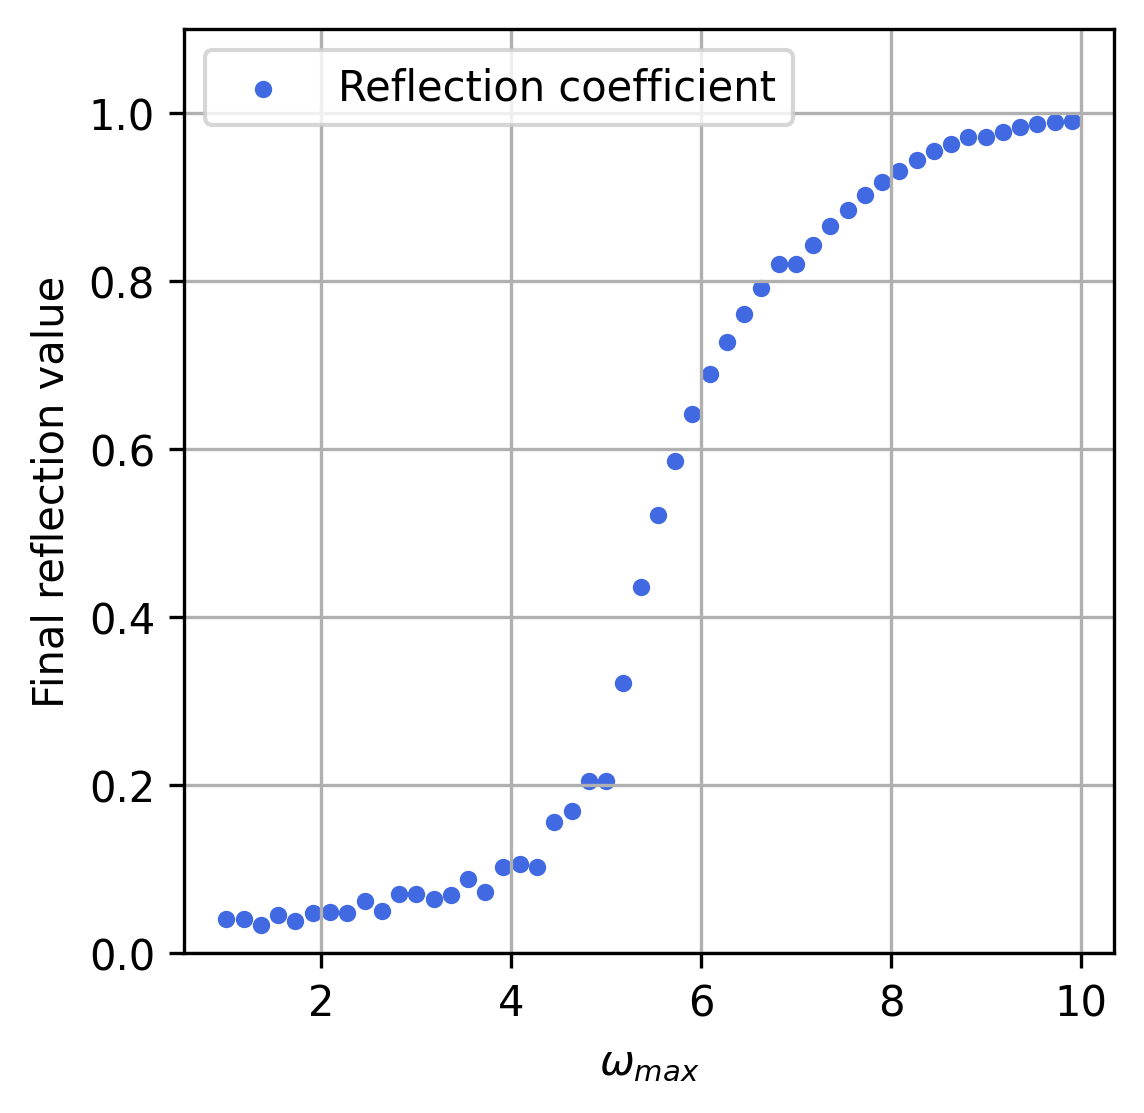

In [26]:
#theoretical test
gamma_phys = gamma
omega_A_phys_tab = omega_A - gamma / (2*pi) * np.log(np.abs(omega_max_tab - omega_A) / omega_A)
reflection_tab = 1 / (1 + (omega_0 - omega_A_phys_tab)**2 / (gamma/2)**2)


fig, ax = plt.subplots(1,1, figsize=(4,4), dpi=resol)
ax.scatter(omega_max_tab, 1-p_1_tab, marker='o', color="royalblue", label='Reflection coefficient', s=10)
#ax.plot(omega_max_tab, reflection_tab, label="Theory")
ax.set_xlabel(r'$\omega_{max}$')

#best UV-cutoff
index_best = np.argmin(p_1_tab)
omega_max_best = omega_max_tab[index_best]

print("Omega max best =", omega_max_best)

ax.set_ylabel('Final reflection value')
ax.set_ylim(0, 1.1)
ax.grid()
ax.legend()
plt.show()